# Algoritmo de maximización de la esperanza para el modelo de mezclas Gaussianas

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Gauss-sum.svg/800px-Gauss-sum.svg.png" width="500px" height="300px" />


> Ya derivamos la forma general del algoritmo de maximización de la esperanza, e hicimos un ejemplo sencillo. Es hora de ver como se aplica este algoritmo a ejemplos más interesantes.

> Comenzaremos por aplicarlo al problema de mezclas Gaussianas.

> **Objetivos:**
> - Aplicar el algoritmo de maximización de la esperanza al modelo de mezclas Gaussianas.

> **Referencias:**
> - Bayesian Methods for Machine Learning course, HSE University, Coursera.

## 1. Recordamos el problema

In [1]:
# Importamos función para generar datos
from bank_customer_data import generate_bank_customer_data
# Importamos scipy.stats.multivariate_normal
from scipy.stats import multivariate_normal
# Importamos pyplot
from matplotlib import pyplot as plt
# Importamos numpy
import numpy as np

In [2]:
# Generamos datos
bank_customer_data = generate_bank_customer_data()

In [3]:
bank_customer_data.head()

,income,debt,labels
0,3.440748,6.003922,1.0
1,0.503947,6.570685,1.0
2,5.255753,2.725688,0.0
3,2.394310,6.942818,1.0
4,3.435503,3.038262,0.0


In [4]:
# Ajustamos parámetros
mu1 = bank_customer_data.loc[
    bank_customer_data["labels"] == 0,
    ["income", "debt"]
].mean().values
mu2 = bank_customer_data.loc[
    bank_customer_data["labels"] == 1,
    ["income", "debt"]
].mean().values
mu3 = bank_customer_data.loc[
    bank_customer_data["labels"] == 2,
    ["income", "debt"]
].mean().values
cov1 = bank_customer_data.loc[
    bank_customer_data["labels"] == 0,
    ["income", "debt"]
].cov().values
cov2 = bank_customer_data.loc[
    bank_customer_data["labels"] == 1,
    ["income", "debt"]
].cov().values
cov3 = bank_customer_data.loc[
    bank_customer_data["labels"] == 2,
    ["income", "debt"]
].cov().values
# Definimos VA
X1 = multivariate_normal(mean=mu1, cov=cov1)
X2 = multivariate_normal(mean=mu2, cov=cov2)
X3 = multivariate_normal(mean=mu3, cov=cov3)

Text(0, 0.5, 'Deuda (x100k MXN)')

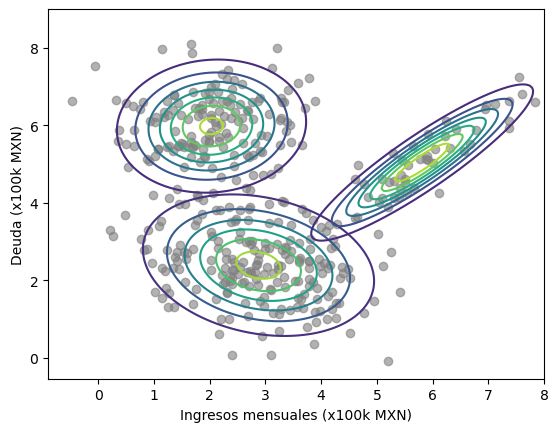

In [5]:
# Datos
plt.scatter(bank_customer_data["income"], bank_customer_data["debt"], c="gray", alpha=0.6)

# Gaussiana 1
x = np.linspace(0, 6, 100)
y = np.linspace(0, 5, 100)
x, y = np.meshgrid(x, y)
z = X1.pdf(np.dstack([x, y]))
plt.contour(x, y, z)

# Gaussiana 2
x = np.linspace(0, 4, 100)
y = np.linspace(4, 9, 100)
x, y = np.meshgrid(x, y)
z = X2.pdf(np.dstack([x, y]))
plt.contour(x, y, z)

# Gaussiana 3
x = np.linspace(3, 8, 100)
y = np.linspace(2, 8, 100)
x, y = np.meshgrid(x, y)
z = X3.pdf(np.dstack([x, y]))
plt.contour(x, y, z)

plt.xlabel("Ingresos mensuales (x100k MXN)")
plt.ylabel("Deuda (x100k MXN)")

Recordamos que en un **modelo de mezclas Gaussianas** tenemos un conjunto de puntos el cual queremos modelar como una mezcla de Gaussianas:

$$
p(x | \theta) = \sum_{c=1}^{k} \pi_c \mathcal{N}(x | \mu_c, \Sigma_c).
$$

Los parámetros de este modelo son:

$$
\theta = \left\{(\pi_c, \mu_c, \Sigma_c): c=1,\dots, k \right\}.
$$

Desde una perspectiva probabilística, esto lo podemos modelar como un modelo de variable latente:

![latent](figures/latent_model.png)

con las siguientes distribuciones:

- $p(t_i=c | \theta) = \pi_c$

- $p(x_i | t_i=c, \theta) = \mathcal{N}(x_i | \mu_c, \Sigma_c)$

## 2. Conexión con algoritmo de maximización de la esperanza

Obtengamos las expresiones detalladas en los pasos del algoritmo de maximización de la esperanza.

### E-step

Para cada punto, debemos calcular la distribución posterior:

$$
q(t_i) = p(t_i|x_i, \theta).
$$

En este caso, usando el teorema de Bayes:

\begin{align}
p(t_i=c | x_i, \theta) & = \frac{p(x_i | t_i=c, \theta) p(t_i=c | \theta)}{p(x_i | \theta)} \\
                       & = \frac{\mathcal{N}(x_i | \mu_c, \Sigma_c) \pi_c}{\sum_{c=1}^{k} \pi_c \mathcal{N}(x | \mu_c, \Sigma_c)}. \\
\end{align}

### M-step

Debemos actualizar los parámetros de modo que maximicen la verosimilitud conjunta:

$$
\max_{\theta} \sum_{i=1}^{N} \mathbb{E}_{q(t_i)} \left[\log p(x_i, t_i| \theta)\right]
$$

Desarrollemos un poco la función a maximizar:

\begin{align}
\sum_{i=1}^{N} \mathbb{E}_{q(t_i)} \left[\log p(x_i, t_i| \theta)\right] 
& = \sum_{i=1}^{N} \sum_{c=1}^{k} q(t_i=c) \log \left[p(x_i| t_i=c \theta) p(t_i=c | \theta)\right] \\
& = \sum_{i=1}^{N} \sum_{c=1}^{k} q(t_i=c) \log \left[\mathcal{N}(x_i | \mu_c, \Sigma_c) \pi_c\right]
\end{align}

Para facilitar el entendimiento, resolvamos el caso escalar:

\begin{align}
\sum_{i=1}^{N} \mathbb{E}_{q(t_i)} \left[\log p(x_i, t_i| \theta)\right] 
& = \sum_{i=1}^{N} \sum_{c=1}^{k} q(t_i=c) \log \left[p(x_i| t_i=c, \theta) p(t_i=c | \theta)\right] \\
& = \sum_{i=1}^{N} \sum_{c=1}^{k} q(t_i=c) \log \left[\mathcal{N}(x_i | \mu_c, \sigma_c^2) \pi_c\right] \\
& = \sum_{i=1}^{N} \sum_{c=1}^{k} q(t_i=c) \log \left[\frac{\pi_c}{\sqrt{2 \pi \sigma_c^2}}\exp\left\{-\frac{(x_i - \mu_c)^2}{2\sigma_c^2}\right\}\right] \\
& = \sum_{i=1}^{N} \sum_{c=1}^{k} q(t_i=c) \left[\log \pi_c - \frac{1}{2}\log 2 \pi - \frac{1}{2}\log\sigma_c^2 -\frac{(x_i - \mu_c)^2}{2\sigma_c^2}\right] := f(\theta)\\
\end{align}

Derivamos respecto a $\mu_c$ e igualamos a cero:

\begin{align}
\frac{\partial f(\theta)}{\partial \mu_c} = \sum_{i=1}^{N} q(t_i=c)\frac{x_i - \mu_c}{\sigma_c^2} & = 0 \\
\Leftrightarrow \sum_{i=1}^{N} q(t_i=c)\left(x_i - \mu_c\right) & = 0 \\
\Leftrightarrow \mu_c & = \frac{\sum_{i=1}^{N} q(t_i=c)x_i}{\sum_{i=1}^{N} q(t_i=c)}.
\end{align}

Derivamos respecto a $\sigma_c^2$ e igualamos a cero:

\begin{align}
\frac{\partial f(\theta)}{\partial \sigma_c^2} = \sum_{i=1}^{N} q(t_i=c)\left[- \frac{1}{2\sigma_c^2}+\frac{(x_i - \mu_c)^2}{2(\sigma_c^2)^2}\right] & = 0 \\
\Leftrightarrow \sum_{i=1}^{N} q(t_i=c)\left[-1+\frac{(x_i - \mu_c)^2}{\sigma_c^2}\right] & = 0 \\
\Leftrightarrow \sigma_c^2 & = \frac{\sum_{i=1}^{N} q(t_i=c)(x_i - \mu_c)^2}{\sum_{i=1}^{N} q(t_i=c)}.
\end{align}

Para el caso de los parámetros $\pi_c$, tenemos que tener en cuenta la restricción $\sum_{c=1}^{k} \pi_c = 1$. El Lagrangiano es:

$$
L(\theta, \lambda) = f(\theta) - \lambda \left(\sum_{c=1}^{k} \pi_c - 1\right).
$$

Las derivadas respecto a $\pi_c$ y a $\lambda$, igualadas a cero, resulta en:

\begin{align}
\frac{\partial L(\theta, \lambda)}{\partial \pi_c} = \sum_{i=1}^{N} q(t_i=c) \frac{1}{\pi_c} - \lambda & = 0 \\
\Leftrightarrow \pi_c & = \frac{\sum_{i=1}^{N} q(t_i=c)}{\lambda}.
\end{align}

\begin{align}
\frac{\partial L(\theta, \lambda)}{\partial \lambda} = \sum_{c=1}^{k} \pi_c - 1 & = 0 \\
\Leftrightarrow \sum_{c=1}^{k} \frac{\sum_{i=1}^{N} q(t_i=c)}{\lambda} - 1 & = 0 \\
\Leftrightarrow \sum_{i=1}^{N} \underbrace{\sum_{c=1}^{k} q(t_i=c)}_{1} - \lambda & = 0 \\
\Leftrightarrow \lambda &= N.
\end{align}

Finalmente:

$$
\pi_c = \frac{\sum_{i=1}^{N} q(t_i=c)}{N}.
$$

**En resumen:**

- $\mu_c = \frac{\sum_{i=1}^{N} q(t_i=c)x_i}{\sum_{i=1}^{N} q(t_i=c)}$.
- $\sigma_c^2 = \frac{\sum_{i=1}^{N} q(t_i=c)(x_i - \mu_c)^2}{\sum_{i=1}^{N} q(t_i=c)}$.
- $\pi_c = \frac{\sum_{i=1}^{N} q(t_i=c)}{N}$.

___
#### Nota:

Acá hemos resuelto el caso escalar para facilitar el entendimiento, sin embargo, también es posible obtener soluciones cerradas en el caso multivariable.

En el caso multivariable ($x \in \mathbb{R}^n$), la función $f(\theta)$ es:

$$
f(\theta) = \sum_{i=1}^{N} \sum_{c=1}^{k} q(t_i=c) \left[\log \pi_c - \frac{1}{2}\log (2 \pi)^n + \frac{1}{2}\log \det(\Lambda_c) - \frac{1}{2}(x_i - \mu_c)^T \Lambda_c (x_i - \mu_c)\right],
$$

donde $\Lambda_c = \Sigma_c^{-1}$.

En este caso, es útil saber los siguientes gradientes:

1. Forma cuadrática respecto al vector ($y \in \mathbb{R}^n$, $Q = Q^T \in\mathbb{R}^{n \times n}$):
   $$
   \frac{\partial y^T Q y}{\partial y} = 2 Q y.
   $$
   
2. Forma cuadrática respecto a la matriz ($y \in \mathbb{R}^n$, $Q = Q^T \in\mathbb{R}^{n \times n}$):
   $$
   \frac{\partial y^T Q y}{\partial Q} = y y^T.
   $$
   
3. Gradiente del log-det ($Q = Q^T \in\mathbb{R}^{n \times n}$):
   $$
   \frac{\partial \log \det (Q)}{\partial Q} = Q^{-1}.
   $$

Con lo que se obtienen los siguientes resultados (análogos al caso escalar):

$$
\mu_c = \frac{\sum_{i=1}^{N} q(t_i=c)x_i}{\sum_{i=1}^{N} q(t_i=c)},
$$

$$
\Sigma_c = \frac{\sum_{i=1}^{N} q(t_i=c)(x_i - \mu_c) (x_i - \mu_c)^T}{\sum_{i=1}^{N} q(t_i=c)},
$$

$$
\pi_c = \frac{\sum_{i=1}^{N} q(t_i=c)}{N}.
$$
___

## 3. En resumen

**Entrenamiento de parámetros para GMM:**

1. Inicializar los parámetros:
   $$
   \theta^0 = \left\{(\pi_c^0, \mu_c^0, \Sigma_c^0): c=1,\dots, k \right\}.
   $$
   
   - $\pi_c^0$ se puede inicializar con una muestra de la distribución de Dirichlet.
   - $\mu_c^0$ se puede inicializar eligiendo aleatoriamente datos de la muestra para entrenar.
   - $\Sigma_c^0$ se puede inicializar con la matriz identidad, o como $R^T R$ donde $R$ es una matriz de números aleatorios.
   
2. Repetir hasta la convergencia ($j=0, 1, \dots$):

   - E-step: para todo $c=1,\dots,k$, para todo $i=1,\dots,N$,
     $$
     q^{j+1}(t_i = c) = \frac{\mathcal{N}(x_i | \mu_c^j, \Sigma_c^j) \pi_c^j}{\sum_{c=1}^{k} \pi_c^j \mathcal{N}(x | \mu_c^j, \Sigma_c^j)}
     $$
     
   - M-step: para todo $c=1,\dots,k$
     $$
     \mu_c^{j+1} = \frac{\sum_{i=1}^{N} q^{j+1}(t_i=c)x_i}{\sum_{i=1}^{N} q^{j+1}(t_i=c)},
     $$

     $$
     \Sigma_c^{j+1} = \frac{\sum_{i=1}^{N} q^{j+1}(t_i=c)(x_i - \mu_c) (x_i - \mu_c)^T}{\sum_{i=1}^{N} q^{j+1}(t_i=c)},
     $$

     $$
     \pi_c^{j+1} = \frac{\sum_{i=1}^{N} q^{j+1}(t_i=c)}{N}.
     $$
     

## 4. Sobre el ejemplo de clientes bancarios

In [8]:
# Importamos sklearn.model_selection.train_test_split
from sklearn.model_selection import train_test_split
# Importamos sklearn.mixture.GaussianMixture
from sklearn.mixture import GaussianMixture

In [9]:
# GaussianMixture model help
GaussianMixture?

Init signature:
GaussianMixture(
    n_components=1,
    *,
    covariance_type='full',
    tol=0.001,
    reg_covar=1e-06,
    max_iter=100,
    n_init=1,
    init_params='kmeans',
    weights_init=None,
    means_init=None,
    precisions_init=None,
    random_state=None,
    warm_start=False,
    verbose=0,
    verbose_interval=10,
)
Docstring:     
Gaussian Mixture.

Representation of a Gaussian mixture model probability distribution.
This class allows to estimate the parameters of a Gaussian mixture
distribution.

Read more in the :ref:`User Guide <gmm>`.

.. versionadded:: 0.18

Parameters
----------
n_components : int, default=1
    The number of mixture components.

covariance_type : {'full', 'tied', 'diag', 'spherical'}, default='full'
    String describing the type of covariance parameters to use.
    Must be one of:

    - 'full': each component has its own general covariance matrix.
    - 'tied': all components share the same general covariance matrix.
    - 'diag': each co

In [10]:
# Datos
X_train, X_test = train_test_split(
    bank_customer_data[["income", "debt"]].values,
    test_size=0.2,
    random_state=42
)

In [36]:
# Modelo de mezclas Gaussianas
gmm_model = GaussianMixture(n_components=3, random_state=42)
# Entrenamiento
gmm_model.fit(X_train)

c:\Users\esjim\anaconda3\envs\meb2025_v4\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


GaussianMixture(n_components=3, random_state=42)

In [37]:
# Parámetros óptimos
gmm_model.means_

array([[2.85659563, 2.41396958],
       [2.08154624, 5.9659117 ],
       [5.8149182 , 5.08040626]])

In [38]:
gmm_model.covariances_

array([[[ 1.15859039, -0.35850456],
        [-0.35850456,  0.85965472]],

       [[ 0.72424285, -0.01815557],
        [-0.01815557,  0.59063112]],

       [[ 1.01992213,  0.93035556],
        [ 0.93035556,  1.02459443]]])

In [39]:
gmm_model.weights_

array([0.50363374, 0.36015786, 0.1362084 ])

In [40]:
# Gaussianas ajustadas
X1 = multivariate_normal(
    mean=gmm_model.means_[0],
    cov=gmm_model.covariances_[0]
)
X2 = multivariate_normal(
    mean=gmm_model.means_[1],
    cov=gmm_model.covariances_[1]
)
X3 = multivariate_normal(
    mean=gmm_model.means_[2],
    cov=gmm_model.covariances_[2]
)

Text(0, 0.5, 'Deuda (x100k MXN)')

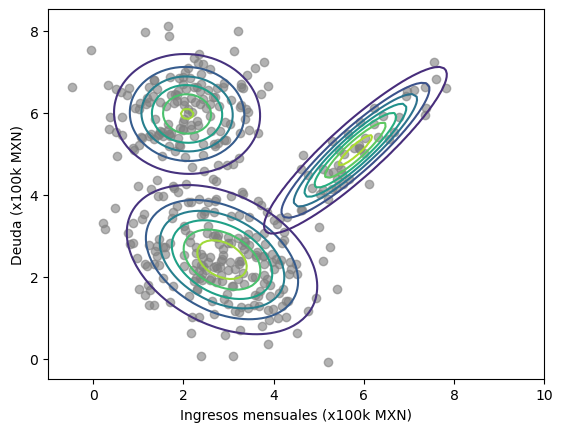

In [41]:
# Datos
plt.scatter(bank_customer_data["income"], bank_customer_data["debt"], c="gray", alpha=0.6)

# Gaussiana 1
x = np.linspace(0, 10, 100)
y = np.linspace(0, 8, 100)
x, y = np.meshgrid(x, y)
z = X1.pdf(np.dstack([x, y]))
plt.contour(x, y, z)

# Gaussiana 2
x = np.linspace(0, 10, 100)
y = np.linspace(0, 8, 100)
x, y = np.meshgrid(x, y)
z = X2.pdf(np.dstack([x, y]))
plt.contour(x, y, z)

# Gaussiana 3
x = np.linspace(0, 10, 100)
y = np.linspace(0, 8, 100)
x, y = np.meshgrid(x, y)
z = X3.pdf(np.dstack([x, y]))
plt.contour(x, y, z)

plt.xlabel("Ingresos mensuales (x100k MXN)")
plt.ylabel("Deuda (x100k MXN)")

c:\Users\esjim\anaconda3\envs\meb2025_v4\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(


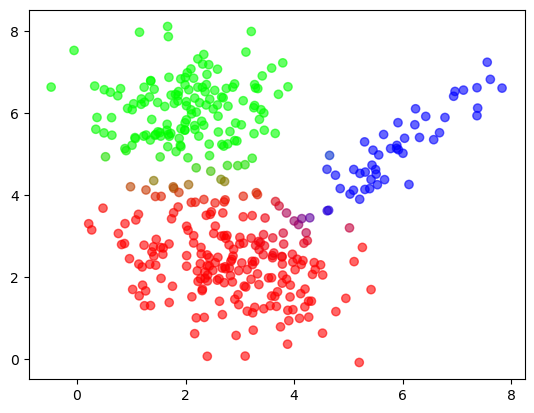

In [42]:
# Por colores - respecto a la probabilidad de pertenencia
plt.scatter(
    bank_customer_data["income"], 
    bank_customer_data["debt"], 
    c=gmm_model.predict_proba(bank_customer_data[["income", "debt"]]),
    alpha=0.6
)

Una de las razones principales para considerar clustering probabilístico era la elección del número de clusters:

$$
p(x | \theta) = \sum_{c=1}^{k} \pi_c \mathcal{N}(x | \mu_c, \Sigma_c).
$$

In [43]:
def log_likelihood_gmm(X, mu, sigma, pi):
    """
    Log-likelihood of the data wrt Gaussian Mixture Model.
    :param data: Data.
    :param mu: Means of the components of the GMM.
    :param sigma: Covariances of the components of the GMM.
    :param pi: Weights of the components of the GMM.
    :return: Log-likelihood of the data wrt GMM.
    """
    # Number of clusters
    k = mu.shape[0]
    # Number of points
    N = X.shape[0]
    
    # Individual likelihood of each point to each normal
    ind_likelihood = np.zeros((N, k))
    for j in range(k):
        ind_likelihood[:, j] = multivariate_normal.pdf(X, mean=mu[j, :], cov=sigma[j, :, :])
    
    # Log likelihood
    log_likelihood = np.log(ind_likelihood.dot(pi)).mean()
        
    return log_likelihood

In [44]:
# División de datos
X_train, X_test = train_test_split(
    bank_customer_data[["income", "debt"]].values,
    test_size=0.2,
)
log_likelihood_train = []
log_likelihood_test = []
for k in range(2, 11):
    # Instanciamos el algoritmo
    gmm_model = GaussianMixture(n_components=k, random_state=42)

    # Entrenamos
    gmm_model.fit(X_train)
    
    # Métrica con datos de entrenamiento
    log_likelihood_train.append(
        log_likelihood_gmm(
            X_train,
            gmm_model.means_,
            gmm_model.covariances_,
            gmm_model.weights_
        )
    )
    
    # Métrica con datos de prueba
    log_likelihood_test.append(
        log_likelihood_gmm(
            X_test,
            gmm_model.means_,
            gmm_model.covariances_,
            gmm_model.weights_
        )
    )

c:\Users\esjim\anaconda3\envs\meb2025_v4\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\esjim\anaconda3\envs\meb2025_v4\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\esjim\anaconda3\envs\meb2025_v4\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\esjim\anaconda3\envs\meb2025_v4\lib\site-packages\sklearn\cluster\_kmeans.py:14

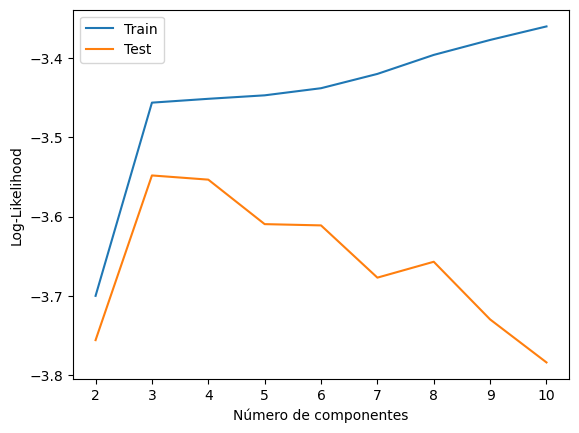

In [45]:
plt.plot(range(2, 11), log_likelihood_train, label="Train")
plt.plot(range(2, 11), log_likelihood_test, label="Test")
plt.xlabel("Número de componentes")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.show()

De esta manera, de acuerdo a la log-verosimilitud sobre el conjunto de pruebas, el número de componentes óptimo es:

In [46]:
# Número de componentes óptimo
log_likelihood_test

[-3.7555777418443497,
 -3.5482130096403877,
 -3.553491266345797,
 -3.609511523042405,
 -3.6111052742748315,
 -3.676891067420695,
 -3.6568921910865413,
 -3.7295161340348137,
 -3.7836587106812116]

## ¡No hay overfitting!

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>